# Estimating hotspot(s) emission and rotational axis from visibilties. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 with r_g=2 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os

import jax
from jax import random
from jax import numpy as jnp
import jax.scipy.ndimage as jnd
import scipy.ndimage as nd

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

import xarray as xr
import flax
from flax.training import train_state
from flax.training import checkpoints
import optax
import numpy as np
import matplotlib.pyplot as plt

import utils, emission_utils, visualization, network_utils, observation_utils
from network_utils import shard

import ehtim as eh
import ehtim.const_def as ehc
from tensorboardX import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm
import ipyvolume as ipv
from ipywidgets import interact
import ipywidgets as widgets

# from jax.config import config
# config.update("jax_debug_nans", True)
%load_ext autoreload
%autoreload 2

2021-10-01 11:05:49.255948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jbz_hdvu because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



In [49]:
# Generate hotspot emission
nt, nx, ny, nz = 64, 64, 64, 64
nt_test = 64
nspots = 1
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco)

nspots = 10
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])
initial_frame = emission_utils.generate_orbit_3d(initial_frame, nt, 1, rot_axis).isel(
    t=np.random.choice(range(0, nt, 5), size=nspots)).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)
emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

normalization_factor = 0.03
emission *= normalization_factor
emission_test *= normalization_factor

print('rotation axis: {}'.format(rot_axis))

rotation axis: [ 0.5        0.        -0.8660254]


In [51]:
# Save emission 
# outpath = 'emission/emission.phi{:1.2f}.theta{:1.2f}.radius{}.std{}.nspots{}_1'.format(phi, theta, orbit_radius, std, nspots)
# outpath_test = 'emission/emission_test.phi{:1.2f}.theta{:1.2f}.radius{}.std{}.nspots{}_1'.format(phi, theta, orbit_radius, std, nspots)
# emission.to_netcdf(outpath)
# emission_test.to_netcdf(outpath_test)

In [4]:
# Load emission 
# emission = xr.load_dataarray('emission/emission.phi0.00.theta1.05.radius3.5.std0.4.nspots10')
# emission_test = xr.load_dataarray('emission/emission_test.phi0.00.theta1.05.radius3.5.std0.4.nspots10')

In [59]:
extent = [(float(emission[dim].min()), float(emission[dim].max())) for dim in ('x', 'y', 'z')]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [52]:
# Generate image plane fluxes
# sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
sensor = sensor.fillna(0.0)

image_plane = emission_utils.integrate_rays(emission, sensor).data.reshape(nt, sensor.num_alpha, sensor.num_beta)
image_plane_test = emission_utils.integrate_rays(emission_test, sensor).data.reshape(nt_test, sensor.num_alpha, sensor.num_beta)

In [53]:
fov = 85.0         # field of view in uas 
array_name = 'ngEHT'

obs_params = {
    'array': eh.array.load_txt('../eht_arrays/{}.txt'.format(array_name)),
    'nt': 128,      # number of time samples 
    'tstart': 4.0,  # start of observations (UTC hr)
    'tstop': 15.5,  # end of observation (UTC hr)
    'tint': 60.0    # integration time
}
obs_empty = observation_utils.empty_eht_obs(**obs_params)
obs_args = {
    'psize': fov / sensor.num_alpha * ehc.RADPERUAS,
    'ra': obs_empty.ra, 
    'dec': obs_empty.dec,
    'rf': obs_empty.rf, 
    'mjd': obs_empty.mjd
}

%matplotlib widget
observation_utils.plot_uv_coverage(obs_empty)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(datalist)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
# Generate visibility measurements
times = np.linspace(obs_params['tstart'], obs_params['tstop'], nt)
movie = eh.movie.Movie(image_plane, times, **obs_args)
obs = movie.observe_same_nonoise(obs_empty, ttype='fast')

times_test = np.linspace(obs_params['tstart'], obs_params['tstop'], nt_test)
movie_test = eh.movie.Movie(image_plane, times_test, **obs_args)
obs_test = movie_test.observe_same_nonoise(obs_empty, ttype='fast')

measurements = observation_utils.padded_obs(obs, 'vis', fill_value=0.0)
measurements_test = observation_utils.padded_obs(obs_test, 'vis', fill_value=0.0)
uv = np.stack((observation_utils.padded_obs(obs, 'u'), 
               observation_utils.padded_obs(obs, 'v')), axis=2)

obs_times = np.array([np.mean(obsdata['time'][0]) for obsdata in obs.tlist()])

Producing clean visibilities from movie with fast FT . . . 
Producing clean visibilities from movie with fast FT . . . 


In [55]:
# Visualize radiance measurements 
%matplotlib widget

fig, ax = plt.subplots(1,2, figsize=(9.5,4))
image_plane_visualization = xr.DataArray(image_plane, dims=['t', 'alpha', 'beta'])
anim = image_plane_visualization.utils_visualization.animate(ax=ax[0])
obs.plotall('uvdist', 'amp', axis=ax[1], ebar=False)
outpath = 'gifs/{}.measurements.fov{:2.1f}.nspots{:d}.theta_{:2.0f}.phi_{:2.0f}.gif'.format(
    array_name, fov, nspots, np.rad2deg(theta), np.rad2deg(phi))
# anim.save(outpath, writer='imagemagick', fps=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/scratch/imaging/projects/bh_nerf/bhNeRF/notebooks/../bhnerf/visualization.py:167: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


In [56]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    norm_images = ( (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity)) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_network(sensor, emission, emission_test, velocity_field, obs_times, hparams, runname, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    tstart = obs_times[0]
    tstop = obs_times[-1]

    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    t, x, y, z, d = train_coords.values()
    train_vis = measurements

    test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    test_vis = measurements_test
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = hparams['batchsize']
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(np.full(t_res_vis, fill_value=tstart), 
                                              np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization

    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_AND_MLP_ROTAXIS_3D_FROM_VIS(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, tstart, tstop)['params']

    def flattened_traversal(fn):
        def mask(data):
            flat = flax.traverse_util.flatten_dict(data)
            return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
        return mask

    tx = optax.chain(
        optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                     mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
        optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                     mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
    )

    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images = intensity_to_nchw(emission.isel(t=0))
        writer.add_images('emission/true', images, global_step=0)

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
                loss_test, _, _, _, _, _ = eval_pstep(
                    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
                    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(loss_test)), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, axis_estimation, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
                    shard(uv[batch_inds, ...]), fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
                )
                axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
                emission_vis = np.reshape(emission_vis[0,0], [x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
                
                # Log emission and rotation axis
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_scalar('rotation/dot_product', np.dot(rot_axis, axis_estimation), global_step=i)
                writer.add_scalar('rotation/norm', np.sqrt(np.dot(axis_estimation, axis_estimation)), global_step=i)
                writer.add_scalar('rotation/x', axis_estimation[0], global_step=i)
                writer.add_scalar('rotation/y', axis_estimation[1], global_step=i)
                writer.add_scalar('rotation/z', axis_estimation[2], global_step=i)
                
            # Training
            batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
            loss_train, state, _, _, _, rand_key = train_pstep(
                velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
                shard(train_vis[batch_inds, ...]), state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(np.mean(loss_train)), global_step=i)
    
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis, axis_estimation

In [57]:
# Training parameters
hparams = {
    'num_iters': 50000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-2,
    'posenc_deg': 3,
    'batchsize': 8,
    'r_min': r_min
}
runname = '{}/rot_axis_MLP.fov{}.batch{}.phi{:2.1f}.theta{:2.1f}.nspots{}'.format(
    array_name, fov, hparams['batchsize'], np.rad2deg(phi), np.rad2deg(theta), nspots
)
state, emission_vis, rot_axis_est = train_network(
    sensor, emission, emission_test, velocity_field, obs_times, hparams, 
    runname=runname, log_period=100, save_period=5000, x_res_vis=64, y_res_vis=64, z_res_vis=64
)
emission_estimate = emission_utils.generate_orbit_3d(
    xr.DataArray(emission_vis[0], coords=initial_frame.coords), nt, velocity_field, rot_axis_est)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


iteration:   0%|          | 0/50000 [00:00<?, ?it/s]

In [31]:
emission_estimate = emission_utils.generate_orbit_3d(
    xr.DataArray(emission_vis[0], coords=initial_frame.coords), nt, velocity_field, rot_axis_est)

In [58]:
extent = [(float(initial_frame[dim].min()), float(initial_frame[dim].max())) for dim in initial_frame.dims]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission_estimate.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [29]:
# Save measurement prediction
plt.rcdefaults()
image_prediction = emission_utils.integrate_rays(emission_estimate, sensor)
image_prediction = xr.DataArray(image_prediction.data.reshape(nt, sensor.num_alpha, sensor.num_beta), dims=['t', 'alpha', 'beta'])

movie_pred = eh.movie.Movie(image_plane, times, **obs_args)
obs_pred = movie_pred.observe_same_nonoise(obs_empty, ttype='fast')

# Visualize radiance measurements 
%matplotlib widget

fig, ax = plt.subplots(1,2, figsize=(9.5,4))
image_plane_visualization = xr.DataArray(image_plane, dims=['t', 'alpha', 'beta'])
anim = image_plane_visualization.utils_visualization.animate(ax=ax[0])
obs_pred.plotall('uvdist', 'amp', axis=ax[1], ebar=False)
outpath = 'gifs/{}.prediction.fov{:2.1f}.nspots{:d}.theta_{:1.1f}.phi_{:1.1f}.gif'.format(
    array_name, fov, nspots, np.rad2deg(theta), np.rad2deg(phi))
# anim.save(outpath, writer='imagemagick', fps=10)

Producing clean visibilities from movie with fast FT . . . 


/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
%matplotlib widget
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.scatter(0,0,0, color='black', s=50)
ax.quiver(0,0,0,*rot_axis, length=0.05, linewidths=3,  label='true')
ax.quiver(0,0,0,*rot_axis_est, length=0.05, linewidths=3, label='estimated', color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## DEBUG

In [22]:
def train_network(sensor, emission, emission_test, velocity_field, obs_times, hparams, runname, batch_inds,
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    tstart = obs_times[0]
    tstop = obs_times[-1]

    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    t, x, y, z, d = train_coords.values()
    train_vis = measurements

    test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    test_vis = measurements_test
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(tstart, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization

    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_AND_ROTAXIS_3D_FROM_VIS_UNCERTAINTY(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, tstart, tstop)['params']

    def flattened_traversal(fn):
        def mask(data):
            flat = flax.traverse_util.flatten_dict(data)
            return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
        return mask

    tx = optax.chain(
        optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                     mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
        optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                     mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
    )

    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)

    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images = intensity_to_nchw(emission.isel(t=0))
        writer.add_images('emission/true', images, global_step=0)

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                # batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
                # batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
                loss_test, _, _, _, _, _ = eval_pstep(
                    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
                    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(loss_test)), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, axis_estimation, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
                    shard(uv[[0], ...]), fov, tstart, tstop, shard(test_vis[[0],...]), state, rand_key
                )
                axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
                emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
                
                # Log emission and rotation axis
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_scalar('rotation/dot_product', np.dot(rot_axis, axis_estimation), global_step=i)
                writer.add_scalar('rotation/x', axis_estimation[0], global_step=i)
                writer.add_scalar('rotation/y', axis_estimation[1], global_step=i)
                writer.add_scalar('rotation/z', axis_estimation[2], global_step=i)

            # Training
            # batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            # batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False, p=p)
            loss_train, state, _, _, _, rand_key = train_pstep(
                velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
                shard(train_vis[batch_inds, ...]), state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(np.mean(loss_train)), global_step=i)
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis, axis_estimation

def train_network_image_plane(sensor, emission, emission_test, velocity_field, obs_times, hparams, runname, batch_inds, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    tstart = obs_times[0]
    tstop = obs_times[-1]

    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    t, x, y, z, d = train_coords.values()
    train_vis = image_plane

    test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    test_vis = image_plane_test
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(tstart, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization

    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_AND_ROTAXIS_3D_FROM_VIS_UNCERTAINTY(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, tstart, tstop)['params']

    def flattened_traversal(fn):
        def mask(data):
            flat = flax.traverse_util.flatten_dict(data)
            return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
        return mask

    tx = optax.chain(
        optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                     mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
        optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                     mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
    )

    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images = intensity_to_nchw(emission.isel(t=0))
        writer.add_images('emission/true', images, global_step=0)

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                # batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
                # batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
                loss_test, _, _, _, _, _ = eval_pstep(
                    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
                    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(loss_test)), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, axis_estimation, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
                    shard(uv[[0], ...]), fov, tstart, tstop, shard(test_vis[[0],...]), state, rand_key
                )
                axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
                emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
                
                # Log emission and rotation axis
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_scalar('rotation/dot_product', np.dot(rot_axis, axis_estimation), global_step=i)
                writer.add_scalar('rotation/x', axis_estimation[0], global_step=i)
                writer.add_scalar('rotation/y', axis_estimation[1], global_step=i)
                writer.add_scalar('rotation/z', axis_estimation[2], global_step=i)

            # Training
            # batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            # batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
            loss_train, state, _, _, _, rand_key = train_pstep(
                velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
                shard(train_vis[batch_inds, ...]), state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(np.mean(loss_train)), global_step=i)
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis, axis_estimation

In [285]:
log_period=1
x_res_vis=64
y_res_vis=64
z_res_vis=64

hparams = {
    'num_iters': 5,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-1,
    'posenc_deg': 3,
    'batchsize': 2,
    'r_min': r_min
}


tstart = obs_times[0]
tstop = obs_times[-1]

# Training / testing coordinates
train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
t, x, y, z, d = train_coords.values()
train_vis = image_plane

test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
test_vis = image_plane_test
t_test, x_test, y_test, z_test, d_test = test_coords.values()

# Emission visualization inputs
t_res_vis = 1
emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
t_vis, x_vis, y_vis, z_vis  = np.meshgrid(tstart, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                          np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                          np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                          indexing='ij')

d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization

# Model setup and initialization
rng = jax.random.PRNGKey(1)
predictor = network_utils.PREDICT_EMISSION_AND_ROTAXIS_3D_FROM_VIS_UNCERTAINTY(posenc_deg=hparams['posenc_deg'])
params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, tstart, tstop)['params']

def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask

tx = optax.chain(
    optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                 mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
    optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                 mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
)

state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
rand_key = jax.random.split(rng, jax.local_device_count())
state = flax.jax_utils.replicate(state)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [286]:
#state.params['axis'] = jnp.array([rot_axis])
state.params['axis'] = jnp.array([[0.44412354, 0.05837725, 0.8940622 ]])
#state.params['axis'] = jnp.array([[0, 0, 0]])

In [288]:
batch_inds = [6]

i = 1
loss_test, _, _, rend, axis, _, grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
state.params['axis'] = state.params['axis'] / jnp.linalg.norm(state.params['axis'])
print('loss: {}'.format(loss_test))
print('grad: {}'.format(grads))
print('state: {}'.format(state.params['axis']))

%matplotlib widget
i = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(rend[0,i], origin='lower')
ax[1].imshow(test_vis[batch_inds[i]], origin='lower')

loss: [0.00471678]
grad: {'axis': ShardedDeviceArray([[-5.8867619e-05,  4.1988096e-04,  1.8263236e-06]], dtype=float32)}
state: [[0.44412333 0.05837722 0.8940618 ]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [541]:
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo200_npix4096.nc')
sensor = sensor.assign_coords({'rho': ('pix', np.sqrt(sensor.alpha**2 + sensor.beta**2))})
sensor = sensor.where(np.abs(sensor.rho - np.sqrt(27)) > 0.25)
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
sensor = sensor.fillna(0.0)

image_plane = emission_utils.integrate_rays(emission, sensor).data.reshape(nt, sensor.num_alpha, sensor.num_beta)
image_plane_test = emission_utils.integrate_rays(emission_test, sensor).data.reshape(nt_test, sensor.num_alpha, sensor.num_beta)

# Visualize radiance measurements 
%matplotlib widget
image_plane_visualization = xr.DataArray(image_plane, dims=['t', 'alpha', 'beta'])
anim = image_plane_visualization.utils_visualization.animate()
# anim.save(outpath, writer='imagemagick', fps=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [287]:
batch_inds = [5]

i = 1
loss_test, _, _, rend, axis, _, grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
state.params['axis'] = state.params['axis'] / jnp.linalg.norm(state.params['axis'])
print('loss: {}'.format(loss_test))
print('grad: {}'.format(grads))
print('state: {}'.format(state.params['axis']))

%matplotlib widget
i = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(rend[0,i], origin='lower')
ax[1].imshow(test_vis[batch_inds[i]], origin='lower')

loss: [0.00462338]
grad: {'axis': ShardedDeviceArray([[ 1.0849355e-05,  3.4945927e-04, -2.8206850e-05]], dtype=float32)}
state: [[0.4441234  0.05837723 0.8940619 ]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [534]:
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo200_npix4096.nc')
sensor = sensor.assign_coords({'rho': ('pix', np.sqrt(sensor.alpha**2 + sensor.beta**2))})
sensor = sensor.where(np.abs(sensor.rho - np.sqrt(27)) < 1e-1, drop=True)
sensor = sensor.where(sensor.r < 10)
x = sensor.x.data
y = sensor.y.data
z = sensor.z.data

ii = 11
ipv.figure()
ipv.view(0, -60, distance=2.5)
ipv.plot(x[ii], y[ii], z[ii])
ipv.volshow(emission.isel(t=0), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
ipv.show()

In [220]:
x = sensor.x.where(sensor.r<5, drop=True).isel(pix=500)
y = sensor.y.where(sensor.r<5, drop=True).isel(pix=500)
z = sensor.z.where(sensor.r<5, drop=True).isel(pix=500)

extent = [(float(emission[dim].min()), float(emission[dim].max())) for dim in ('x', 'y', 'z')]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.scatter(x, y, z)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

In [140]:
batch_inds = [5]
loss_train, state, _, _, _, rand_key, grads = train_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
    shard(train_vis[batch_inds, ...]), state, rand_key
)
state.params['axis'] = state.params['axis'] / jnp.linalg.norm(state.params['axis'])
print('loss: {}'.format(loss_train))
print('grad: {}'.format(grads))
print('state: {}'.format(state.params['axis']))

loss: [0.00513504]
grad: {'axis': ShardedDeviceArray([[ 0.0003377 ,  0.00026869, -0.00018529]], dtype=float32)}
state: [[0.39606112 0.12123612 0.9101854 ]]


In [131]:
%matplotlib widget
i = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(rend[0,i], origin='lower')
ax[1].imshow(test_vis[batch_inds[i]], origin='lower')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
%matplotlib widget
image_plane_visualization = xr.DataArray(test_vis[batch_inds,...], dims=['t', 'alpha', 'beta'])
anim = image_plane_visualization.utils_visualization.animate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [81]:
%matplotlib widget
image_plane_visualization = xr.DataArray(rend[0], dims=['t', 'alpha', 'beta'])
anim = image_plane_visualization.utils_visualization.animate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [221]:
batch_inds = [6]
i = 1
loss_test, _, _, rend, axis, _, grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(loss_test)
print(grads)

[0.00490387]
{'axis': ShardedDeviceArray([[-2.2118911e-09, -2.2700988e-09,  1.0477379e-09]], dtype=float32)}


In [220]:
batch_inds = [7]
i = 1
loss_test, _, _, rend, axis, _, grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(loss_test)
print(grads)

[0.00477987]
{'axis': ShardedDeviceArray([[-0.00047558, -0.00043153,  0.00026442]], dtype=float32)}


In [205]:
batch_inds = [6]
i = 1
loss_test, _, _, rend, axis, _, grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(loss_test)
print(grads)

[0.00490387]
{'axis': ShardedDeviceArray([[4.2130705e-07, 5.3631084e-08, 8.5367355e-07]], dtype=float32)}


In [201]:
grads

{'axis': ShardedDeviceArray([[ 0.00033812,  0.00026874, -0.00018444]], dtype=float32)}

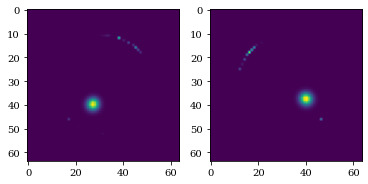

In [196]:
i = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(rend[0,i])
ax[1].imshow(test_vis[batch_inds[i]])

In [280]:
x = sensor.x.data.ravel()
y = sensor.y.data.ravel()
z = sensor.z.data.ravel()

extent = [(float(emission[dim].min()), float(emission[dim].max())) for dim in ('x', 'y', 'z')]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.scatter(x, y, z, size=0.3, marker='sphere')
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

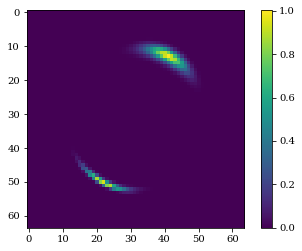

In [815]:
i=-1
plt.figure()
plt.imshow(image_plane[batch_inds[i]])
plt.colorbar()

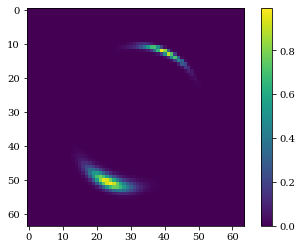

In [816]:
plt.figure()
plt.imshow(rend[0,i])
plt.colorbar()

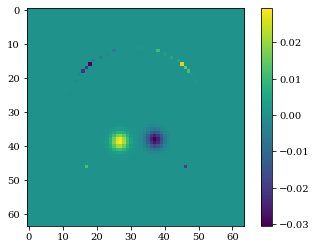

In [758]:
i = 4
plt.figure()
plt.imshow(rend[1,i]-image_plane[batch_inds[i]])
plt.colorbar()

In [629]:
# Testing and Vsualization
batch_inds = np.array([1,0])
loss_test, _, _, _, _, _,grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(grads)

{'axis': ShardedDeviceArray([[-0.00121563, -0.00507453,  0.        ]], dtype=float32)}


In [309]:
batch_inds = np.array([0,1])
loss_train, state, _, _, _, rand_key, grads = train_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
    shard(train_vis[batch_inds, ...]), state, rand_key
)
print(grads)

{'axis': ShardedDeviceArray([[0.00137613, 0.0018365 , 0.01977683]], dtype=float32)}


In [296]:
batch_inds = [0]

u = shard(uv[batch_inds, ...])[0,...,0]
v = shard(uv[batch_inds, ...])[0,...,1]

use_jax= True
import jax.scipy.ndimage as _nd
interp_order = 1

In [297]:
_np = jnp

image = np.zeros((64,64))

if image.ndim == 2:
    image = image[None,...]

nb, ny, nx = image.shape   
b = np.tile(np.array(range(nb))[...,None], u.shape[-1])

rad_per_uas = 4.848136811094136e-12
psize = fov / nx * rad_per_uas
freqs = _np.fft.fftshift(_np.fft.fftfreq(n=nx, d=psize))
fft = _np.fft.fftshift(_np.fft.fft2(_np.fft.ifftshift(image)))

In [298]:
pulsefac = observation_utils.trianglePulse2D(u, v, psize, use_jax=use_jax)
phase = observation_utils.extra_phase(u, v, psize, image.shape, use_jax=use_jax)
coords = _np.stack((v, u), axis=-1)

In [300]:
fov_uv = _np.array((freqs[-1]-freqs[0], freqs[-1]-freqs[0]))
fourier_image_coords = _np.concatenate((
    b[...,None], 
    utils.world_to_image_coords(coords, fov_uv, (nx, ny), use_jax=use_jax) + 0.5
), axis=-1)

visibilities = _nd.map_coordinates(fft, fourier_image_coords.T, order=interp_order).T

In [174]:
batch_inds = np.array([1,0])
loss_train, state, _, _, _, rand_key, grads = train_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
    shard(train_vis[batch_inds, ...]), state, rand_key
)
print(grads)

(2, 171, 2)
(2, 64, 64)


TypeError: mul got incompatible shapes for broadcasting: (171, 2), (2, 171).

In [163]:
shard(uv[batch_inds, ...]).shape

(1, 2, 171, 2)

In [162]:
batch_inds = np.array([1,0])
loss_train, state, _, _, _, rand_key, grads = train_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]), fov, tstart, tstop,
    shard(train_vis[batch_inds, ...]), state, rand_key
)
print(grads)

{'axis': ShardedDeviceArray([[-0.00083896, -0.00018808,  0.        ]], dtype=float32)}


In [150]:
# Testing and Vsualization
batch_inds = np.array([1,0])
loss_test, _, _, _, _, _,grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(grads)

{'axis': ShardedDeviceArray([[-0.00083896, -0.00018808,  0.        ]], dtype=float32)}


In [151]:
# Testing and Vsualization
batch_inds = np.array([0,1])
loss_test, _, _, _, _, _,grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(grads)

{'axis': ShardedDeviceArray([[0., 0., 0.]], dtype=float32)}


In [140]:
i = 1

# Testing and Vsualization
batch_inds = np.array([1])
loss_test, _, _, _, _, _,grads = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(uv[batch_inds, ...]),
    fov, tstart, tstop, shard(test_vis[batch_inds,...]), state, rand_key
)
print(grads)

{'axis': ShardedDeviceArray([[-0.00107691, -0.00027849,  0.        ]], dtype=float32)}


In [139]:
grads

{'axis': ShardedDeviceArray([[0., 0., 0.]], dtype=float32)}

In [21]:
%matplotlib widget
plt.imshow(image_plane[0])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
%matplotlib widget
plt.imshow(ren[0,0])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
%matplotlib widget
t1 = int(64*(t[batch_inds] - tstart) / (tstop - tstart))
plt.figure()
plt.imshow(image_plane_test[t1])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
plt.figure()
plt.imshow(rend[0,0])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …